In [1]:
from wfdb import io, plot
import wfdb
import os
import gc
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
%matplotlib notebook
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout, Input
from keras.layers import CuDNNLSTM as LSTM
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
import keras

Using TensorFlow backend.


In [2]:
def comments_to_dict(comments):
    key_value_pairs = [comment.split(':') for comment in comments]
    return {pair[0]: pair[1] for pair in key_value_pairs}    

In [7]:
#TODO save this locally
db = 'ptbdb'
record_names = io.get_record_list(db)

In [3]:
def record_to_row(record, patient_id):
    row = {}
    row['patient'] = patient_id
    row['name'] = record.record_name
    row['label'] = comments_to_dict(record.comments)['Reason for admission'][1:]
    row['signals'] = record.p_signal
    row['signal_length'] = record.sig_len
    channels = record.sig_name
    signals = record.p_signal.transpose()
    
    row['channels'] = channels
    
    for channel, signal in zip(channels, signals):
        row[channel] = signal
        
    return row

In [6]:
records = []
for record_name in tqdm(record_names):
    record = io.rdrecord(record_name=os.path.join('data', record_name))
    label = comments_to_dict(record.comments)['Reason for admission'][1:]
    records.append(record_to_row(record, record_name.split('/')[0]))
    
channels = record.sig_name
df_records = pd.DataFrame(records)    

NameError: name 'record_names' is not defined

In [5]:
labels = df_records['label'].unique()
df_records['label'].value_counts()

NameError: name 'df_records' is not defined

In [96]:
selected_labels = ['Healthy control', 'Myocardial infarction', 'Bundle branch block', 'Dysrhythmia', 'Hypertrophy']
df_selected = df_records.loc[df_records['label'].isin(selected_labels)]
label_map = {label: value for label, value in zip(selected_labels, range(len(selected_labels)))}

In [97]:
test_patients = []
train_patients = []
test_size = 0.33
channels
for label in selected_labels:
    df_selected = df_records.loc[df_records['label'] == label]
    patients = df_selected['patient'].unique()
    n_test = math.ceil(len(patients)*test_size)
    test_patients+=list(np.random.choice(patients, n_test, replace=False))
    train_patients+=list(patients[np.isin(patients, test_patients, invert=True)])
#df_selected['patient'].sample(len())

In [98]:
def make_set(df_data, channels, label_map, window_size=2048):
    n_windows = 0
    
    for _, record in tqdm(df_data.iterrows()):
        n_windows+= record['signals'].shape[0]//window_size

    dataX = np.zeros((n_windows, len(channels), window_size))
    dataY = np.zeros((n_windows, len(label_map)))

    nth_window = 0
    for i, (_, record) in enumerate(tqdm(df_data.iterrows())):
        # Set class
        
        data = record['signals'].transpose()
        n_rows = data.shape[-1]
        n_windows = n_rows//window_size
        dataX[nth_window:nth_window+n_windows] = np.array([data[:,i*window_size:(i+1)*window_size] for i in range(n_windows)])
        dataY[nth_window:nth_window+n_windows][:, label_map[record.label]] = 1
        nth_window+=n_windows
        
    return dataX, dataY

In [99]:
df_patient_records = df_records.set_index('patient')
df_train_patients = df_patient_records.loc[train_patients]
df_test_patients = df_patient_records.loc[train_patients]
trainX, trainY = make_set(df_train_patients, channels, label_map)
testX, testY = make_set(df_test_patients, channels, label_map)

In [75]:
window_size=2048
n_windows = 0
nth_window = 0
for _, record in tqdm(df_test_patients.iterrows()):
    n_windows+= record['signals'].shape[0]//window_size

dataX = np.zeros((n_windows, len(channels), window_size))
dataY = np.zeros((n_windows, len(label_map)))

In [ ]:
def make_model_enc_dec(input_shape, output_dim, stateful=False, dropout=0.2):
    print("model dim: ", input_shape, output_dim)
    model = Sequential()
    model.add(LSTM(256, return_sequences=True, input_shape=input_shape, batch_size=None, stateful=stateful))
    model.add(Dropout(dropout))
    model.add(LSTM(128, return_sequences=True), stateful=stateful)
    model.add(Dropout(dropout))
    model.add(LSTM(64), return_sequences=True, stateful=stateful)
    model.add(Dropout(dropout))
    model.add(LSTM(128), return_sequences=True, stageful=stateful)
    model.add(Dropout(dropout))
    model.add(LSTM(256), return_sequences=True, stageful=stateful)
    model.add(Dropout(dropout))
    model.add(LSTM(input_shape[-1]))
    #model.add(Dense(output_dim, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    return model


In [100]:
def make_model(input_shape, output_dim):
    print("model dim: ", input_shape, output_dim)
    model = Sequential()
    model.add(LSTM(256, return_sequences=True, input_shape=input_shape, batch_size=None))
    model.add(Dropout(0.2))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64))
    model.add(Dropout(0.2))
    model.add(Dense(output_dim, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    return model

In [101]:
filepath = os.path.join('models', "weights-improvement-{epoch:02d}-bigger.hdf5")
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')

model_name = 'first_lstm'
model_folder = os.path.join('tensorlogs', model_name + "-logs/")

if not os.path.isdir(model_folder):
    n_logs = 0
else:
    n_logs = len(os.listdir(model_folder))
    
tensorboard_logs = os.path.join(model_folder, "%inth_run"%n_logs)
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=tensorboard_logs, write_graph=False)
callbacks = [checkpoint, tensorboard_callback]

model = make_model((trainX.shape[1], trainX.shape[2]), trainY.shape[-1])

model.fit(trainX, trainY, epochs=50, batch_size=512, callbacks=callbacks)


model dim:  (15, 2048) 5
Epoch 1/50
17286/17286 [==============================] - ETA: 1:11 - loss: 1.642 - ETA: 53s - loss: 1.458 - ETA: 45s - loss: 1.30 - ETA: 40s - loss: 1.19 - ETA: 34s - loss: 1.13 - ETA: 30s - loss: 1.08 - ETA: 26s - loss: 1.05 - ETA: 24s - loss: 1.02 - ETA: 21s - loss: 0.99 - ETA: 19s - loss: 0.97 - ETA: 18s - loss: 0.95 - ETA: 16s - loss: 0.95 - ETA: 15s - loss: 0.93 - ETA: 14s - loss: 0.93 - ETA: 13s - loss: 0.92 - ETA: 12s - loss: 0.91 - ETA: 11s - loss: 0.91 - ETA: 10s - loss: 0.90 - ETA: 10s - loss: 0.89 - ETA: 9s - loss: 0.8888 - ETA: 8s - loss: 0.886 - ETA: 7s - loss: 0.881 - ETA: 7s - loss: 0.876 - ETA: 6s - loss: 0.870 - ETA: 6s - loss: 0.866 - ETA: 5s - loss: 0.859 - ETA: 4s - loss: 0.858 - ETA: 4s - loss: 0.853 - ETA: 3s - loss: 0.851 - ETA: 2s - loss: 0.848 - ETA: 2s - loss: 0.846 - ETA: 1s - loss: 0.843 - ETA: 0s - loss: 0.842 - 27s 2ms/step - loss: 0.8399

Epoch 00001: loss improved from inf to 0.83993, saving model to models\weights-improvement-0

17286/17286 [==============================] - ETA: 4s - loss: 0.065 - ETA: 4s - loss: 0.066 - ETA: 4s - loss: 0.063 - ETA: 4s - loss: 0.062 - ETA: 4s - loss: 0.063 - ETA: 4s - loss: 0.069 - ETA: 3s - loss: 0.065 - ETA: 3s - loss: 0.064 - ETA: 3s - loss: 0.066 - ETA: 3s - loss: 0.066 - ETA: 3s - loss: 0.067 - ETA: 3s - loss: 0.066 - ETA: 3s - loss: 0.066 - ETA: 2s - loss: 0.063 - ETA: 2s - loss: 0.064 - ETA: 2s - loss: 0.065 - ETA: 2s - loss: 0.065 - ETA: 2s - loss: 0.063 - ETA: 2s - loss: 0.064 - ETA: 2s - loss: 0.064 - ETA: 1s - loss: 0.063 - ETA: 1s - loss: 0.064 - ETA: 1s - loss: 0.065 - ETA: 1s - loss: 0.066 - ETA: 1s - loss: 0.065 - ETA: 1s - loss: 0.066 - ETA: 0s - loss: 0.067 - ETA: 0s - loss: 0.067 - ETA: 0s - loss: 0.067 - ETA: 0s - loss: 0.067 - ETA: 0s - loss: 0.067 - ETA: 0s - loss: 0.067 - ETA: 0s - loss: 0.068 - 5s 287us/step - loss: 0.0684

Epoch 00017: loss did not improve from 0.06714
Epoch 18/50
17286/17286 [==============================] - ETA: 4s - loss: 0.081 - E

17286/17286 [==============================] - ETA: 4s - loss: 0.019 - ETA: 4s - loss: 0.015 - ETA: 4s - loss: 0.015 - ETA: 4s - loss: 0.017 - ETA: 4s - loss: 0.018 - ETA: 4s - loss: 0.018 - ETA: 3s - loss: 0.017 - ETA: 3s - loss: 0.018 - ETA: 3s - loss: 0.017 - ETA: 3s - loss: 0.017 - ETA: 3s - loss: 0.017 - ETA: 3s - loss: 0.017 - ETA: 3s - loss: 0.016 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.017 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.017 - ETA: 2s - loss: 0.017 - ETA: 2s - loss: 0.017 - ETA: 1s - loss: 0.017 - ETA: 1s - loss: 0.017 - ETA: 1s - loss: 0.017 - ETA: 1s - loss: 0.017 - ETA: 1s - loss: 0.016 - ETA: 1s - loss: 0.017 - ETA: 0s - loss: 0.017 - ETA: 0s - loss: 0.017 - ETA: 0s - loss: 0.017 - ETA: 0s - loss: 0.017 - ETA: 0s - loss: 0.017 - ETA: 0s - loss: 0.017 - ETA: 0s - loss: 0.017 - 5s 286us/step - loss: 0.0178

Epoch 00033: loss improved from 0.02126 to 0.01783, saving model to models\weights-improvement-33-bigger.hdf5
Epoch 34/50
17286/172

17286/17286 [==============================] - ETA: 4s - loss: 0.030 - ETA: 4s - loss: 0.030 - ETA: 4s - loss: 0.025 - ETA: 4s - loss: 0.021 - ETA: 4s - loss: 0.017 - ETA: 4s - loss: 0.016 - ETA: 3s - loss: 0.019 - ETA: 3s - loss: 0.017 - ETA: 3s - loss: 0.020 - ETA: 3s - loss: 0.020 - ETA: 3s - loss: 0.021 - ETA: 3s - loss: 0.022 - ETA: 3s - loss: 0.022 - ETA: 2s - loss: 0.022 - ETA: 2s - loss: 0.022 - ETA: 2s - loss: 0.022 - ETA: 2s - loss: 0.022 - ETA: 2s - loss: 0.022 - ETA: 2s - loss: 0.021 - ETA: 2s - loss: 0.021 - ETA: 1s - loss: 0.021 - ETA: 1s - loss: 0.021 - ETA: 1s - loss: 0.021 - ETA: 1s - loss: 0.022 - ETA: 1s - loss: 0.022 - ETA: 1s - loss: 0.021 - ETA: 0s - loss: 0.022 - ETA: 0s - loss: 0.021 - ETA: 0s - loss: 0.021 - ETA: 0s - loss: 0.021 - ETA: 0s - loss: 0.021 - ETA: 0s - loss: 0.021 - ETA: 0s - loss: 0.021 - 5s 287us/step - loss: 0.0214

Epoch 00049: loss did not improve from 0.00677
Epoch 50/50
17286/17286 [==============================] - ETA: 4s - loss: 0.006 - E

In [102]:
output = model.predict_classes(testX)

In [103]:
(output == testY.argmax(axis=1)).sum()/len(output)

0.9979173897952099

In [104]:
confusion_matrix(testY.argmax(axis=1), output)

array([[ 2830,    21,     1,     0,     0],
       [    1, 13099,     1,     8,     3],
       [    0,     1,   637,     0,     0],
       [    0,     0,     0,   452,     0],
       [    0,     0,     0,     0,   232]], dtype=int64)

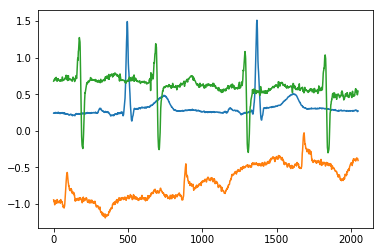

In [19]:
channel = channels[1]
plt.plot(df_healthy.iloc[3][channel][0:window_size])
plt.plot(df_myo.iloc[4][channel][0:window_size])
plt.plot(df_dys.iloc[2][channel][0:window_size])
plt.show()

In [68]:
record.label = comments_to_dict(record.comments)['Reason for admission']

In [69]:
record.label

' Myocardial infarction'

In [66]:
comments_to_dict(record.comments)

{'Acute infarction (localization)': ' infero-latera',
 'Additional diagnoses': ' Diabetes mellitus',
 'Additional medication': ' Heparin Isosorbit-Mononitrate ASA Diazepam',
 'Admission date': ' 29-Sep-90',
 'Aorta (at rest) (syst/diast)': ' 160/64 cmH2O',
 'Aorta (at rest) mean': ' 106 cmH2O',
 'Cardiac index (at rest)': ' n/a',
 'Cardiac index (load)': ' n/a',
 'Cardiac output (at rest)': ' n/a',
 'Cardiac output (load)': ' n/a',
 'Catheterization date': ' 16-Oct-90',
 'Chest X-ray': ' Heart size upper limit of norm',
 'Diagnose': '',
 'Dosage (lytic agent)': ' 30 mg',
 'ECG date': ' 18/10/1990',
 'Echocardiography': ' n/a',
 'Former infarction (localization)': ' no',
 'Hemodynamics': '',
 'In hospital medication': ' ASA Isosorbit-Mononitrate Ca-antagonist Amiloride+Chlorothiazide Glibenclamide Insulin',
 'Infarction date': ' 29-Sep-90',
 'Infarction date (acute)': ' 29-Sep-90',
 'Left coronary artery stenoses (RCX)': ' No stenoses',
 'Left coronary artery stenoses (RIVA)': ' RIVA 70

In [4]:
io.dl_database(db, 'data', records)

Finished downloading files
